# CSUB First Year Student Retention Prediction
**Making a binary prediction of whether a first year student will return the following semester or not**

1. [Data Prep](#Data-Prep)
  1. [Import Libraries](#Import-Libraries)
  2. [Import Data from AWS S3](#Import-Data-from-AWS-S3)
  3. [Examine Data Types](#Examine-Data-Types)
  4. [Check Correlations](#Check-Correlations)
  5. [Check Null Values](#Check-Null-Values)
  6. [Exploration Category Value](#Exploration-Category-Value)
  7. [Final Data Exploration](#Final-Data-Exploration)
2. [Implementation](#Implementation)
  1. [Dataset Split in Training and Validation](#Dataset-Split-in-Training-and-Validation)
  2. [Training the Linear Model](#Training-the-Linear-Model)
3. [Deploy for Real Time Prediction](#Deploy-for-Real-Time-Prediction)
  1. [Set up hosting for the Model](#Set-up-hosting-for-the-Model)
4. [Evaluate the Model for use](#Evaluate-the-Model-for-use)
  1. [Check Single Record](#Check-Single-Record)
  2. [Check a set of Records](#Check-a-set-of-Records)
  3. [Get Prediction](#Get-Prediction)  
  4. [Display Prediction Results](#Display-Prediction-Results)
  5. [Final Evaluation Result](#Final-Evaluation-Result)
5. [Delete the Endpoint](#Delete-the-Endpoint)

## Data Prep
<b>Examine student cohort data</b><br>
Linear Learner accepts CSV or recordIO-warpped protobuf
- CSV = No headers and label must be in the first column
- Check correlation and Standard Deviation
- Feature engineering
- Convert categorical data to numeric value
Reference: https://www.datacamp.com/community/tutorials/categorical-data

### Import Libraries
- Pandas, Numpy, sklearn, boto3, sagemaker

In [2]:
#Import libraries
import pandas as pd
import numpy as np
from numpy import array
from sklearn.metrics import f1_score
import copy
import boto3
import re
from sagemaker import get_execution_role
import os
import io
import time
import json
import sagemaker.amazon.common as smac
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Define the S3 Bucket Name
bucket = 'sagemaker-student-retention-11062019' 

#To check the user role or who I am
role = get_execution_role()  

### Import Data from AWS S3 ###
- File format: csv
- Bucket: sagemaker-student-retention
- File name: student_cohort_data.csv

In [284]:
#Instantiate an instance of the Boto3 SDK and scope to the S3 bucket
s3 = boto3.resource('s3')

#KEY very common phrase used to describe an S3 object
KEY = 'FTFR_Fall_2017.csv'
KEY2 = 'FTFR_Fall_2018.csv'

#Download the dataset to the notebook instance
s3.Bucket(bucket).download_file(KEY, 'FTFR_Fall_2017.csv')

#Prediction on fall 2018 FTFR data - will be used for real-time prediction
s3.Bucket(bucket).download_file(KEY2, 'FTFR_Fall_2018.csv')

In [285]:
#Introduction to Pandas
data = pd.read_csv('FTFR_Fall_2017.csv')

#Check data
data.head()

,STUDENTID,RETURNED,AGE,SEX_CODE,IPEDS_REP_CAT,US_CITIZEN,RES_STATUS_CODE,INTERNATIONAL_STU,DEG_OBJ_CODE,DSS_DISABILITY,...,INDEPENDENT_FAMILY_SIZE,FIRST_GEN,EARLY_START_ENG,EARLY_START_MATH,HIGH_SCHOOL_GPA,COLLEGE_PREP_ENGLISH,COLLEGE_PREP_MATHEMATICS,COLLEGE_PREP_LAB_SCIENCE,UNITS_TAKEN,IS_FT
0,1591304,1,18,F,7,1,1,0,2,0,...,99,0,2,7,3.4,8,8,6,10,0
1,1539291,1,18,F,7,1,1,0,2,0,...,99,0,2,7,3.7,8,8,6,10,0
2,1683344,0,18,M,1,1,1,0,3,0,...,99,1,2,2,2.9,8,6,6,12,1
3,1644292,1,18,F,7,1,1,0,3,0,...,99,0,1,1,3.0,8,6,4,10,0
4,1618851,0,23,M,1,1,1,0,3,0,...,99,0,2,2,2.6,8,7,8,8,0


### Examine Data Types ###
Check data types within the dataframe

In [286]:
#Gather information of the data type
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 22 columns):
STUDENTID                   1422 non-null int64
RETURNED                    1422 non-null int64
AGE                         1422 non-null int64
SEX_CODE                    1422 non-null object
IPEDS_REP_CAT               1422 non-null int64
US_CITIZEN                  1422 non-null int64
RES_STATUS_CODE             1422 non-null int64
INTERNATIONAL_STU           1422 non-null int64
DEG_OBJ_CODE                1422 non-null int64
DSS_DISABILITY              1422 non-null int64
DEPENDENT_FAMILY_SIZE       1422 non-null int64
INDEPENDENT_INCOME_CODE     1422 non-null int64
INDEPENDENT_FAMILY_SIZE     1422 non-null int64
FIRST_GEN                   1422 non-null int64
EARLY_START_ENG             1422 non-null int64
EARLY_START_MATH            1422 non-null int64
HIGH_SCHOOL_GPA             1422 non-null float64
COLLEGE_PREP_ENGLISH        1422 non-null int64
COLLEGE_PREP_MATHEMATICS  

### Check Correlations ###
An example to check correlationships between the features
- Gender vs Unit Load

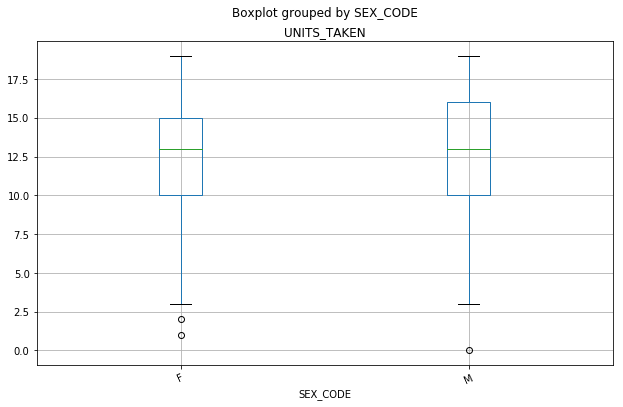

In [287]:
# One of the common way to analyze the relationship between a categorical feature and a continuous feature is to plot 
# a boxplot. The boxplot is a simple way of representing statistical data on a plot in which a rectangle is drawn to represent
# the second and third quartiles, usually with a vertical line inside to indicate the median value. The lower and upper
# quartiles are shown as horizontal lines at either side of the rectangle.

data.boxplot('UNITS_TAKEN', 'SEX_CODE', rot = 25, figsize = (10,6))

### Check Null Values ###

In [288]:
#Next, we need to check all the null values in the dataset
print(data.isnull().sum())

STUDENTID                   0
RETURNED                    0
AGE                         0
SEX_CODE                    0
IPEDS_REP_CAT               0
US_CITIZEN                  0
RES_STATUS_CODE             0
INTERNATIONAL_STU           0
DEG_OBJ_CODE                0
DSS_DISABILITY              0
DEPENDENT_FAMILY_SIZE       0
INDEPENDENT_INCOME_CODE     0
INDEPENDENT_FAMILY_SIZE     0
FIRST_GEN                   0
EARLY_START_ENG             0
EARLY_START_MATH            0
HIGH_SCHOOL_GPA             0
COLLEGE_PREP_ENGLISH        0
COLLEGE_PREP_MATHEMATICS    0
COLLEGE_PREP_LAB_SCIENCE    0
UNITS_TAKEN                 0
IS_FT                       0
dtype: int64


### Exploration Category Value ###

In [289]:
#Another Exploratory Data Analysis (EDA) step that we can do on categorical features is the frequency distribution of 
#categories within the feature, which can be done with the .value_counts() method:

print(data['SEX_CODE'].value_counts())

#to count distinct categories
print("\nCount distinct categories: ")
print(data['SEX_CODE'].value_counts().count())

F    866
M    556
Name: SEX_CODE, dtype: int64

Count distinct categories: 
2


In [290]:
#Auto generate number for category data
labels = data['SEX_CODE'].astype('category').cat.categories.tolist()
replace_gender = {'SEX_CODE':{k: v for k, v in zip(labels, list(range(1,len(labels)+1)))}}
print(replace_gender)

#Make another copy of the data that stores converted value
cat_data_replace = data.copy()

#Replace country category to numeric value
cat_data_replace.replace(replace_gender, inplace=True)

#verify data
#print(cat_data_replace.head())

{'SEX_CODE': {'F': 1, 'M': 2}}


### Final Data Exploration

Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:

- The total number of students, n_students.
- The total number of features for each student, n_features.
- The number of those students who returned, n_returned.
- The number of those students who dropped, n_dropped.
- The retention rate of the students in percent (%).

In [291]:
#Remove first column of student id
data = cat_data_replace.copy()
data.drop(labels=['STUDENTID'], axis=1, inplace=True)
data.head()

,RETURNED,AGE,SEX_CODE,IPEDS_REP_CAT,US_CITIZEN,RES_STATUS_CODE,INTERNATIONAL_STU,DEG_OBJ_CODE,DSS_DISABILITY,DEPENDENT_FAMILY_SIZE,...,INDEPENDENT_FAMILY_SIZE,FIRST_GEN,EARLY_START_ENG,EARLY_START_MATH,HIGH_SCHOOL_GPA,COLLEGE_PREP_ENGLISH,COLLEGE_PREP_MATHEMATICS,COLLEGE_PREP_LAB_SCIENCE,UNITS_TAKEN,IS_FT
0,1,18,1,7,1,1,0,2,0,2,...,99,0,2,7,3.4,8,8,6,10,0
1,1,18,1,7,1,1,0,2,0,3,...,99,0,2,7,3.7,8,8,6,10,0
2,0,18,2,1,1,1,0,3,0,6,...,99,1,2,2,2.9,8,6,6,12,1
3,1,18,1,7,1,1,0,3,0,4,...,99,0,1,1,3.0,8,6,4,10,0
4,0,23,2,1,1,1,0,3,0,3,...,99,0,2,2,2.6,8,7,8,8,0


In [292]:
# TODO: Calculate number of students
n_students = data.shape[0]

# TODO: Calculate number of features
n_features = data.shape[1] - 1

# Data filtering using .loc[rows, columns]
# TODO: Count returned students
returned_cnt = data.loc[data.RETURNED == 1, 'RETURNED']
n_returned = returned_cnt.shape[0]

# TODO: Count dropped students
dropped_cnt = data.loc[data.RETURNED == 0, 'RETURNED']
n_dropped = dropped_cnt.shape[0]

# TODO: Calculate retentation rate
total = float(n_dropped + n_returned)
retention_rate = float(n_returned * 100 / total)

# Print the results
print("Total number of students: " + str(n_students))
print("Number of features: " + str(n_features))
print("Number of students who returned: " + str(n_returned))
print("Number of students who dropped: " + str(n_dropped))
print("Retention rate of the dataset: %.2f " % retention_rate)

Total number of students: 1422
Number of features: 20
Number of students who returned: 1090
Number of students who dropped: 332
Retention rate of the dataset: 76.65 


## Implementation

For the next step, we split the data (both features and corresponding labels) into training, validation, and test sets. 

### Dataset Split in Training and Validation
- Using 1137 training points (80%) and 285 validation points (20%). 
- Set a random_state for the function(s)
- Store the results train, validation

In [293]:
train, validation = np.split(data.sample(frac=1), [int(.8*len(data))])

train.head()

,RETURNED,AGE,SEX_CODE,IPEDS_REP_CAT,US_CITIZEN,RES_STATUS_CODE,INTERNATIONAL_STU,DEG_OBJ_CODE,DSS_DISABILITY,DEPENDENT_FAMILY_SIZE,...,INDEPENDENT_FAMILY_SIZE,FIRST_GEN,EARLY_START_ENG,EARLY_START_MATH,HIGH_SCHOOL_GPA,COLLEGE_PREP_ENGLISH,COLLEGE_PREP_MATHEMATICS,COLLEGE_PREP_LAB_SCIENCE,UNITS_TAKEN,IS_FT
1310,1,18,2,7,1,1,0,3,0,2,...,99,0,2,2,3.6,8,8,8,19,1
110,1,18,1,7,1,1,0,2,0,4,...,99,1,2,1,3.1,8,6,4,14,1
921,1,18,1,4,1,1,0,2,0,2,...,99,0,2,2,3.3,8,8,8,16,1
642,1,18,2,7,1,0,0,3,0,4,...,99,0,1,7,3.6,8,6,6,12,1
1025,1,18,1,7,0,1,0,3,0,5,...,99,0,2,7,3.6,8,8,12,13,1


In [294]:
validation.head()

,RETURNED,AGE,SEX_CODE,IPEDS_REP_CAT,US_CITIZEN,RES_STATUS_CODE,INTERNATIONAL_STU,DEG_OBJ_CODE,DSS_DISABILITY,DEPENDENT_FAMILY_SIZE,...,INDEPENDENT_FAMILY_SIZE,FIRST_GEN,EARLY_START_ENG,EARLY_START_MATH,HIGH_SCHOOL_GPA,COLLEGE_PREP_ENGLISH,COLLEGE_PREP_MATHEMATICS,COLLEGE_PREP_LAB_SCIENCE,UNITS_TAKEN,IS_FT
355,1,18,1,7,1,1,0,0,0,5,...,99,0,2,2,4.0,8,9,6,13,1
923,1,19,1,7,0,0,0,3,0,4,...,99,1,2,2,3.4,8,8,6,16,1
1389,1,19,2,7,1,1,0,3,0,5,...,99,1,2,2,3.8,8,12,8,14,1
498,1,19,2,4,0,0,1,3,0,99,...,99,1,7,7,0.0,0,0,0,6,0
371,0,18,1,7,1,1,0,3,0,5,...,99,1,2,2,3.6,8,8,12,13,1


In [295]:
train['RETURNED'].value_counts()

1    865
0    272
Name: RETURNED, dtype: int64

In [296]:
validation['RETURNED'].value_counts()

1    225
0     60
Name: RETURNED, dtype: int64

In [297]:
# Show the results of the split
print("Training set has " + str(train.shape[0]) + " samples")
print("Validation set has " + str(validation.shape[0]) + " samples")

Training set has 1137 samples
Validation set has 285 samples


### Training the Linear Learner Model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed. In this example that takes between 7 and 11 minutes. Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

In [298]:
#Save training data into train.csv and stored at S3 bucket
np.savetxt('train.csv', train, delimiter=',')
key = 'train.csv'
s3_train_data = 's3://{}/{}'.format(bucket,key)
boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('train.csv')
print('Done writing to {}'.format(s3_train_data))

Done writing to s3://sagemaker-student-retention-11062019/train.csv


In [299]:
#Save validation data into validation.csv and stored at S3 bucket
np.savetxt('validation.csv', validation, delimiter=',')
key1 = 'validation.csv'
s3_validation_data = 's3://{}/{}'.format(bucket,key1)
boto3.Session().resource('s3').Bucket(bucket).Object(key1).upload_file('validation.csv')
print('Done writing to {}'.format(s3_validation_data))

Done writing to s3://sagemaker-student-retention-11062019/validation.csv


### Configure SageMaker ML Model with Hyperparameters
These are parameters that are set by users to facilitate the estimation of model parameters from data.

In [301]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner')
output_location = 's3://sagemaker-student-retention-11062019/output'

sess = sagemaker.Session()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       train_volume_size = 100,
                                       train_max_run = 3600,
                                       input_mode= 'File',
                                       output_path=output_location,
                                       sagemaker_session=sess)

linear.set_hyperparameters(binary_classifier_model_selection_criteria='f1',
                           feature_dim=20,
                           predictor_type='binary_classifier',
                           mini_batch_size=10)

ll_train_data = sagemaker.session.s3_input(
    s3_train_data, 
    distribution='FullyReplicated',
    content_type='text/csv;label_size=1', 
    s3_data_type='S3Prefix')

ll_validation_data = sagemaker.session.s3_input(
    s3_validation_data, 
    distribution='FullyReplicated',
    content_type='text/csv;label_size=1', 
    s3_data_type='S3Prefix')

linear.fit({'train':ll_train_data, 'validation': ll_validation_data})

2019-11-07 19:44:12 Starting - Starting the training job...
2019-11-07 19:44:16 Starting - Launching requested ML instances......
2019-11-07 19:45:23 Starting - Preparing the instances for training.........
2019-11-07 19:47:12 Downloading - Downloading input data
2019-11-07 19:47:12 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[11/07/2019 19:47:29 INFO 139640019552064] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5024674064234683, "sum": 0.5024674064234683, "min": 0.5024674064234683}}, "EndTime": 1573156062.863271, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1573156062.86321}

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5022622878091377, "sum": 0.5022622878091377, "min": 0.5022622878091377}}, "EndTime": 1573156062.863346, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1573156062.863333}

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5012910374423913, "sum": 0.5012910374423913, "min": 0.5012910374423913}}, "EndTime": 1573156062.863402, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": 

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5219270197691116, "sum": 0.5219270197691116, "min": 0.5219270197691116}}, "EndTime": 1573156070.514393, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1573156070.514339}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5237863367637702, "sum": 0.5237863367637702, "min": 0.5237863367637702}}, "EndTime": 1573156070.514474, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1573156070.514455}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5219023862771228, "sum": 0.5219023862771228, "min": 0.5219023862771228}}, "EndTime": 1573156070.514545, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learne

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5028355539890758, "sum": 0.5028355539890758, "min": 0.5028355539890758}}, "EndTime": 1573156080.01518, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1573156080.015114}

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5054223248833104, "sum": 0.5054223248833104, "min": 0.5054223248833104}}, "EndTime": 1573156080.015265, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1573156080.015245}

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5025230031264456, "sum": 0.5025230031264456, "min": 0.5025230031264456}}, "EndTime": 1573156080.015319, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": 

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.519672599091994, "sum": 0.519672599091994, "min": 0.519672599091994}}, "EndTime": 1573156091.808594, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1573156091.808539}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5226667210064103, "sum": 0.5226667210064103, "min": 0.5226667210064103}}, "EndTime": 1573156091.808673, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1573156091.808654}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.519603346301391, "sum": 0.519603346301391, "min": 0.519603346301391}}, "EndTime": 1573156091.808743, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "e

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5188729214457284, "sum": 0.5188729214457284, "min": 0.5188729214457284}}, "EndTime": 1573156104.648918, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1573156104.648858}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5222873525281923, "sum": 0.5222873525281923, "min": 0.5222873525281923}}, "EndTime": 1573156104.648992, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1573156104.64898}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5188067090194837, "sum": 0.5188067090194837, "min": 0.5188067090194837}}, "EndTime": 1573156104.649045, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learn


2019-11-07 19:48:44 Uploading - Uploading generated training model
2019-11-07 19:48:44 Completed - Training job completed
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5186635002625727, "sum": 0.5186635002625727, "min": 0.5186635002625727}}, "EndTime": 1573156108.939678, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1573156108.939624}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5221812647000879, "sum": 0.5221812647000879, "min": 0.5221812647000879}}, "EndTime": 1573156108.939751, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1573156108.939738}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.518598394267327, "sum": 0.518598394267327, "min": 0.518598394267327}}, "EndT

Training seconds: 118
Billable seconds: 118


## Deploy for Real Time Prediction

### Set up hosting for the Model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [303]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

--------------------------------------------------------------------------------------------------------------------------!

## Evaluate the Model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [308]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

modelT = np.array(train.iloc[1:2, 1:])

modelT

array([[18. ,  1. ,  7. ,  1. ,  1. ,  0. ,  2. ,  0. ,  4. ,  9. , 99. ,
         1. ,  2. ,  1. ,  3.1,  8. ,  6. ,  4. , 14. ,  1. ]])

In [309]:
train.head(2)

,RETURNED,AGE,SEX_CODE,IPEDS_REP_CAT,US_CITIZEN,RES_STATUS_CODE,INTERNATIONAL_STU,DEG_OBJ_CODE,DSS_DISABILITY,DEPENDENT_FAMILY_SIZE,...,INDEPENDENT_FAMILY_SIZE,FIRST_GEN,EARLY_START_ENG,EARLY_START_MATH,HIGH_SCHOOL_GPA,COLLEGE_PREP_ENGLISH,COLLEGE_PREP_MATHEMATICS,COLLEGE_PREP_LAB_SCIENCE,UNITS_TAKEN,IS_FT
1310,1,18,2,7,1,1,0,3,0,2,...,99,0,2,2,3.6,8,8,8,19,1
110,1,18,1,7,1,1,0,2,0,4,...,99,1,2,1,3.1,8,6,4,14,1


### Check Single Record
Now let's try getting a prediction for a single record.

In [310]:
result = linear_predictor.predict(modelT[0])
print(result)

{'predictions': [{'score': 0.7176311612129211, 'predicted_label': 1.0}]}


OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the student will return, while `0` denotes that we are predicting the student will not return.

Let's do a whole batch of records and evaluate our predictive accuracy.

### Check a set of Records

In [311]:
data_2018 = pd.read_csv('FTFR_Fall_2018.csv')

#data_2018.head()
print(data_2018.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 21 columns):
RETURNED                    1472 non-null int64
AGE                         1472 non-null int64
SEX_CODE                    1472 non-null int64
IPEDS_REP_CAT               1472 non-null int64
US_CITIZEN                  1472 non-null int64
RES_STATUS_CODE             1472 non-null int64
INTERNATIONAL_STU           1472 non-null int64
DEG_OBJ_CODE                1472 non-null int64
DSS_DISABILITY              1472 non-null int64
DEPENDENT_FAMILY_SIZE       1472 non-null int64
INDEPENDENT_INCOME_CODE     1472 non-null int64
INDEPENDENT_FAMILY_SIZE     1472 non-null int64
FIRST_GEN                   1472 non-null int64
EARLY_START_ENG             1472 non-null int64
EARLY_START_MATH            1472 non-null int64
HIGH_SCHOOL_GPA             1472 non-null float64
COLLEGE_PREP_ENGLISH        1472 non-null int64
COLLEGE_PREP_MATHEMATICS    1472 non-null int64
COLLEGE_PREP_LAB_SCIENCE   

In [312]:
model_predict = np.array(data_2018.iloc[:, 1:])
model_predict

array([[24.,  1.,  7., ...,  8., 16.,  1.],
       [47.,  1.,  2., ...,  4.,  6.,  0.],
       [23.,  1.,  7., ...,  4., 13.,  1.],
       ...,
       [19.,  2.,  4., ...,  8., 15.,  1.],
       [18.,  2.,  8., ...,  7., 13.,  1.],
       [20.,  2.,  7., ...,  4., 16.,  1.]])

### Get Prediction 

In [313]:
predictions = []

for array in model_predict:
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

# Convert result to int
predictions.astype(int)

#print(result)

array([1, 0, 1, ..., 1, 1, 1])

### Display Prediction Results

In [314]:
data_2018['Predicted'] = predictions.astype(int)

data_2018.head()

,RETURNED,AGE,SEX_CODE,IPEDS_REP_CAT,US_CITIZEN,RES_STATUS_CODE,INTERNATIONAL_STU,DEG_OBJ_CODE,DSS_DISABILITY,DEPENDENT_FAMILY_SIZE,...,FIRST_GEN,EARLY_START_ENG,EARLY_START_MATH,HIGH_SCHOOL_GPA,COLLEGE_PREP_ENGLISH,COLLEGE_PREP_MATHEMATICS,COLLEGE_PREP_LAB_SCIENCE,UNITS_TAKEN,IS_FT,Predicted
0,1,24,1,7,1,1,0,0,0,99,...,1,6,8,3.7,8,8,8,16,1,1
1,1,47,1,2,1,1,0,3,0,99,...,0,6,7,3.4,8,6,4,6,0,0
2,1,23,1,7,1,1,0,2,0,99,...,1,6,1,3.3,8,8,4,13,1,1
3,1,23,1,7,1,1,0,2,0,99,...,1,6,7,3.6,8,6,4,16,1,1
4,1,21,1,7,1,1,0,3,0,99,...,1,6,8,3.7,8,8,6,14,1,1


### Final Evaluation Result

In [317]:
#Save validation data into validation.csv and stored at S3 bucket
np.savetxt('prediction.csv', data_2018, delimiter=',')
key3 = 'prediction.csv'
s3_prediction_data = 's3://{}/{}'.format(bucket,key3)
boto3.Session().resource('s3').Bucket(bucket).Object(key3).upload_file('prediction.csv')
print('Done writing to {}'.format(s3_prediction_data))

Done writing to s3://sagemaker-student-retention-11062019/prediction.csv


## Delete the Endpoint

Run the delete_endpoint line in the cell below so you won't be billed for usage of additional resources.  
This will remove the hosted endpoint we created and avoid any charges from a stray instance being left on.

In [318]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)